### Loading data for exploring long-duration energy storage ###

In [1]:
! pip install xarray

In [2]:
! pip install netCDF4

In [3]:
# Import local modules
import os
import sys
import glob

# Import third-party modules
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4 as nc

May have to install xarray (indeed, or other modules), easiest way to do this is to pip install.

In [4]:
# Look at the files in the data directory
os.listdir('CLEARHEADS_data')

['NUTS_0_wp_ofs_sim_1_historical_loc_weighted.nc',
 'NUTS_0_sp_historical.nc',
 'README_ERA5.txt',
 'NUTS_0_wp_ons_sim_1_historical_loc_weighted.nc']

### Data description ###

Data are from: https://researchdata.reading.ac.uk/321/

#### Demand ####

* None currently - Hannah will provide full demand time series from 1950.

#### Wind power ####

* Onshore - *NUTS_0_wp_ons_sim_1_historical_loc_weighted.nc* - Hourly area-averaged onshore wind power capacity factor data at NUTS0 level across Europe, from 01/01/1950 - 31/12/2020. Weighted by the locations of known and proposed future wind farms from thewindpower.net (simulation 1).

* Offshore *NUTS_0_wp_ofs_sim_1_historical_loc_weighted.nc* - Hourly area-averaged offshore wind power capacity factor data at NUTS0 level across Europe, from 01/01/1950 - 31/12/2020. Weighted by the locations of known and proposed future wind farms from thewindpower.net (simulation 1).

#### Solar power ####

* *NUTS_0_ssrd_historical.nc* - Hourly area-averaged solar power capacity factors at NUTS0 level across Europe, from 01/01/1950 - 31/12/2020.

Goal is to load this into a Pandas DataFrame as daily data, to be able to quantify demand-net-renewables.

In [5]:
# define a function to read the data
def load_data(
    filename: str,
    target_resolution: str = "D",
    start_date: str = "1950-01-01",
    time_units: str = "h",
    directory: str = "CLEARHEADS_data/",
    index: str = "time_in_hours_from_first_jan_1950",
    columns: str = "NUTS",
    values: str = "timeseries_data",
):
    """
    Load data from a netCDF file into a pandas DataFrame.
    
    Inputs:

    filename: str
        The name of the netCDF file to load.

    target_resolution: str
        The target resolution for the data. Default is "d" for daily output.

    start_date: str
        The start date for the data. Default is "1950-01-01".

    time_units: str
        The time units for the raw data. Default is "h" for hours.

    directory: str
        The directory where the data is stored. Default is "data/".

    index: str
        The name of the index column. Default is "time_in_hours_from_first_jan_1950".

    columns: str
        The name of the columns. Default is "NUTS".

    values: str
        The name of the values. Default is "timeseries_data".

    Returns:

    data: pd.DataFrame
        The data in a pandas DataFrame.
    
    """
    # Assert that the file exists
    assert os.path.exists(os.path.join(directory, filename)), f"File {filename} not found."

    # Load the data
    data = xr.open_dataset(os.path.join(directory, filename))

    # Assert that NUTS_keys is a data variable
    assert "NUTS_keys" in data.variables, "NUTS_keys not found in data variables."

    # Print the NUTS keys
    print(f"Regions: {data.NUTS_keys.values}")

    # Get the NUTS keys
    regions = data.NUTS_keys.values

    # Turn the data into a DataFrame
    data = data.to_dataframe()

    # Pivot the dataframe
    data = data.reset_index().pivot(
        index=index,
        columns=columns,
        values=values,
    )

    # Assign the NUTS keys to the columns
    data.columns = regions

    # Convert the time index to a datetime index
    data.index = pd.to_datetime(data.index, unit=time_units, origin=start_date)

    # Resample the data
    data = data.resample(target_resolution).mean()

    return data

In [6]:
# Test the function
wp_ofs = load_data(
    filename="NUTS_0_wp_ofs_sim_1_historical_loc_weighted.nc",   
)

Regions: ['UK' 'IE' 'NL' 'FR' 'BE' 'DE' 'DK' 'NO' 'SE' 'ES' 'LI' 'LT' 'AT']


<Axes: xlabel='time_in_hours_from_first_jan_1950'>

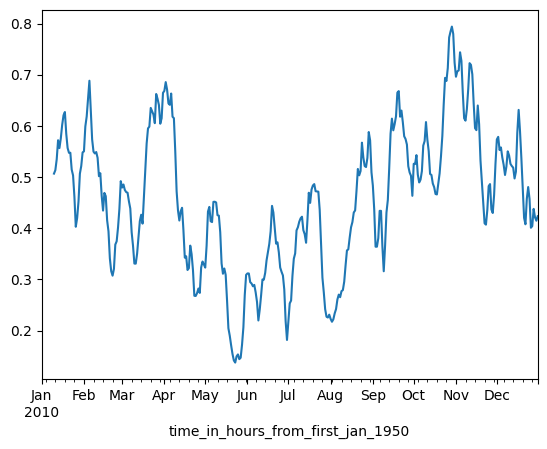

In [7]:
# Subset the data to 2010
wp_ofs_2010 = wp_ofs.loc["2010"]

# # PLot the UK offshore wind power output
# wp_ofs_2010["UK"].plot()

# Apply a 10-day rolling mean
wp_ofs_2010["UK"].rolling(10).mean().plot()

In [8]:
# add the suffix wp_ofs to the column names
wp_ofs = wp_ofs.add_suffix("_wp_ofs")

In [9]:
# Load the onshore wind power data
wp_ons = load_data(
    filename="NUTS_0_wp_ons_sim_1_historical_loc_weighted.nc",
)

Regions: ['UK' 'IE' 'NL' 'FR' 'BE' 'DE' 'DK' 'NO' 'SE' 'ES' 'LI' 'LT' 'AT']


In [10]:
# add the suffix wp_ons to the column names
wp_ons = wp_ons.add_suffix("_wp_ons")

In [11]:
# join the dataframes
wp = wp_ofs.join(wp_ons)

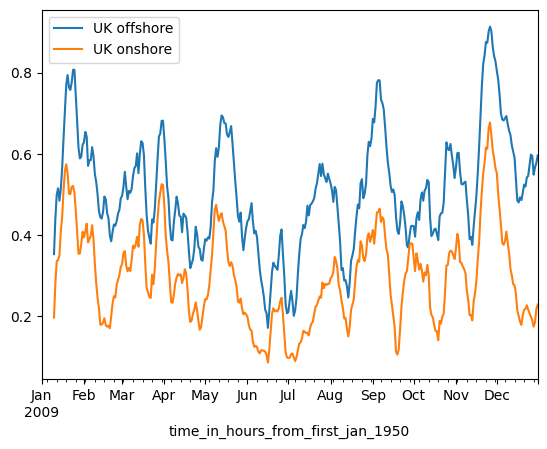

In [12]:
# Restrict to 2009
wp_2009 = wp.loc["2009"]

# Plot the 10-day rolling mean of the UK offshore and onshore wind power
wp_2009["UK_wp_ofs"].rolling(10).mean().plot(label="UK offshore")
wp_2009["UK_wp_ons"].rolling(10).mean().plot(label="UK onshore")

# Include a legend
plt.legend()

In [13]:
# Load in the solar power data
sp = load_data(
    filename="NUTS_0_sp_historical.nc",
)

Regions: ['AT' 'AL' 'BY' 'BE' 'BA' 'BG' 'HR' 'CZ' 'DK' 'EE' 'FI' 'FR' 'DE' 'GR'
 'HU' 'IE' 'IT' 'XK' 'LV' 'LT' 'LU' 'MK' 'MD' 'ME' 'NL' 'NO' 'PL' 'PT'
 'RO' 'RS' 'SK' 'SI' 'ES' 'SE' 'CH' 'TR' 'UA' 'UK']


In [14]:
# Add a suffix for solar power (sp)
sp = sp.add_suffix("_sp")

In [15]:
# Join the wind power and solar power data
data = wp.join(sp)

In [16]:
# rename index "time_in_hours_from_first_jan_1950" to "time"
data.index.rename("time", inplace=True)

In [17]:
data.columns

Index(['UK_wp_ofs', 'IE_wp_ofs', 'NL_wp_ofs', 'FR_wp_ofs', 'BE_wp_ofs',
       'DE_wp_ofs', 'DK_wp_ofs', 'NO_wp_ofs', 'SE_wp_ofs', 'ES_wp_ofs',
       'LI_wp_ofs', 'LT_wp_ofs', 'AT_wp_ofs', 'UK_wp_ons', 'IE_wp_ons',
       'NL_wp_ons', 'FR_wp_ons', 'BE_wp_ons', 'DE_wp_ons', 'DK_wp_ons',
       'NO_wp_ons', 'SE_wp_ons', 'ES_wp_ons', 'LI_wp_ons', 'LT_wp_ons',
       'AT_wp_ons', 'AT_sp', 'AL_sp', 'BY_sp', 'BE_sp', 'BA_sp', 'BG_sp',
       'HR_sp', 'CZ_sp', 'DK_sp', 'EE_sp', 'FI_sp', 'FR_sp', 'DE_sp', 'GR_sp',
       'HU_sp', 'IE_sp', 'IT_sp', 'XK_sp', 'LV_sp', 'LT_sp', 'LU_sp', 'MK_sp',
       'MD_sp', 'ME_sp', 'NL_sp', 'NO_sp', 'PL_sp', 'PT_sp', 'RO_sp', 'RS_sp',
       'SK_sp', 'SI_sp', 'ES_sp', 'SE_sp', 'CH_sp', 'TR_sp', 'UA_sp', 'UK_sp'],
      dtype='object')

Now we have wind power (onshore and offshore) and solar power capacity factors loaded into a dataframe at daily resolution, we now want to grab demand data from S2S4E (shorter period, but should still be useful in the meantime while we wait for data from Hannah).

In [18]:
# Load the demand data
wd_demand_path = "S2S4E_data/ERA5_weather_dependent_demand_1979_2018.csv"

# Load the demand data
demand = pd.read_csv(wd_demand_path)

In [19]:
# Convert Unnamed: 0 to a datetime index
demand.index = pd.to_datetime(demand["Unnamed: 0"])

In [20]:
# Drop the Unnamed: 0 column
demand.drop("Unnamed: 0", axis=1, inplace=True)

In [21]:
# Rename Unnamed: 0 as time
demand.index.rename("time", inplace=True)

In [22]:
# Rename the columns
# Split by "_wd_" and take the first element
demand.columns = [column.split("_wd_")[0] for column in demand.columns]

In [23]:
# Add the suffix "_demand"
demand = demand.add_suffix("_demand")

In [24]:
demand.head()

,Austria_demand,Belgium_demand,Bulgaria_demand,Croatia_demand,Czech_Republic_demand,Denmark_demand,Finland_demand,France_demand,Germany_demand,Greece_demand,...,Norway_demand,Poland_demand,Portugal_demand,Romania_demand,Slovakia_demand,Slovenia_demand,Spain_demand,Sweden_demand,Switzerland_demand,United_Kingdom_demand
time,,,,,,,,,,,,,,,,,,,,,
1979-01-01,8.746085,13.285360,4.480123,2.085154,9.884955,4.783249,12.956948,84.793019,65.897470,5.664130,...,25.146248,23.280473,6.086594,7.226054,3.787129,1.610934,30.384541,23.744467,7.982498,50.640896
1979-01-02,9.491813,12.498014,5.557895,2.349787,9.788056,4.681681,13.114426,87.320377,65.425365,6.039870,...,23.944521,22.604713,6.196767,8.219921,4.005506,1.747526,30.824693,23.068526,8.423941,47.996807
1979-01-03,9.443403,12.691651,6.347009,2.380751,9.606212,4.688280,13.146203,85.420152,64.623033,7.135994,...,24.518593,22.347208,6.064753,8.420241,3.977617,1.768301,30.861329,23.994230,8.289964,47.691554
1979-01-04,9.500878,12.419853,6.255989,2.310251,9.650421,4.763490,13.228586,78.860953,65.101535,7.208864,...,24.663098,22.999755,6.315494,8.368188,3.973771,1.740730,30.850026,24.785046,8.244870,47.716700
1979-01-05,9.631089,12.872013,5.758050,2.309691,9.853166,4.737475,13.160649,80.113847,65.658008,6.301761,...,23.663964,22.410664,6.581421,8.344409,4.035315,1.737661,31.378043,24.976397,8.212811,49.088719


In [25]:
# Merge demand data with the wind and solar power data
data = data.merge(demand, how='left', left_index=True, right_index=True)

In [27]:
# Save this dataframe
save_path = "saved_data/supply_demand_data.csv"

# Save the data
data.to_csv(save_path)

In [29]:
# Subset to 2010
data_2009 = data.loc["2009"]

Text(0, 0.5, 'Demand (GW)')

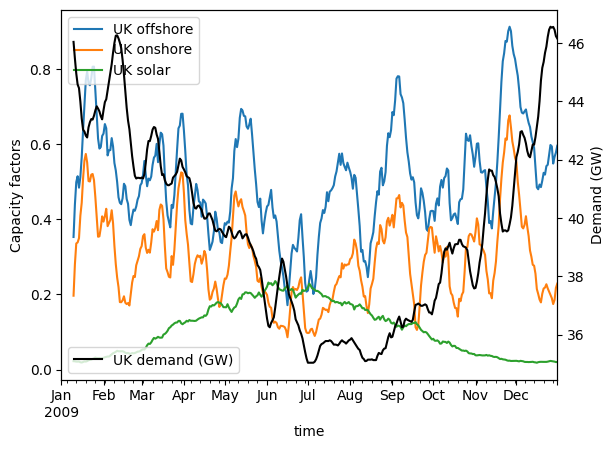

In [35]:
# Plot the 10-day rolling mean of the UK offshore wind power and onshore wind power
# and solar power
data_2009["UK_wp_ofs"].rolling(10).mean().plot(label="UK offshore")
data_2009["UK_wp_ons"].rolling(10).mean().plot(label="UK onshore")
data_2009["UK_sp"].rolling(10).mean().plot(label="UK solar")

# Include y-axis labels
plt.ylabel("Capacity factors")

# Include a legend in the top left
plt.legend(loc="upper left")

# new axis for demand
ax2 = plt.twinx()

# Plot the UK demand
data_2009["United_Kingdom_demand"].rolling(10).mean().plot(label="UK demand (GW)", color="black", ax=ax2)

# Include a legend
plt.legend()

# Include a second y-axis label
ax2.set_ylabel("Demand (GW)")